In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from open_spiel.python.algorithms import random_agent

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.CIgame import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment
from igraph import Graph

def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    attacker = DQN(player_id=0,
                    state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features,
                   num_actions=num_actions)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    agents = [attacker]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    action_list = np.loadtxt(fname, dtype=int)
    action_list= [map.get(str(a)) for a in action_list]
    rewards, lcc, actions = EvaluateACTION(env, action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker,title,plot_grid,grid):    
    figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(12, 10))
    #figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(22, 20))
    for i, graph_name in enumerate(file_list):
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker[0],attacker[1],GRAPH.copy())
        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "../MAS/FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        #CI
        path = "../MAS/CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions = implement_Bench(fname,GRAPH.copy(),map)
        
        #CoreHD
        path = "../MAS/CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions =  implement_Bench(fname,GRAPH.copy(),map)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''


        x =  np.flip(np.arange(N)[N:0:-1]/N)
        
        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'pink',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')

    figure.text(0.5, 0.05,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.05, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    plt.savefig("./Figure_WithFeature/"+title)
    plt.show()

In [12]:

BA =  500
parameter = ["./utils/params_Feature.json"]
attacker= [torch.load('./model/CI_BA_Graph_WithFeature/model_BAGraph_'+str(BA))]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (29x1 and 5x2)

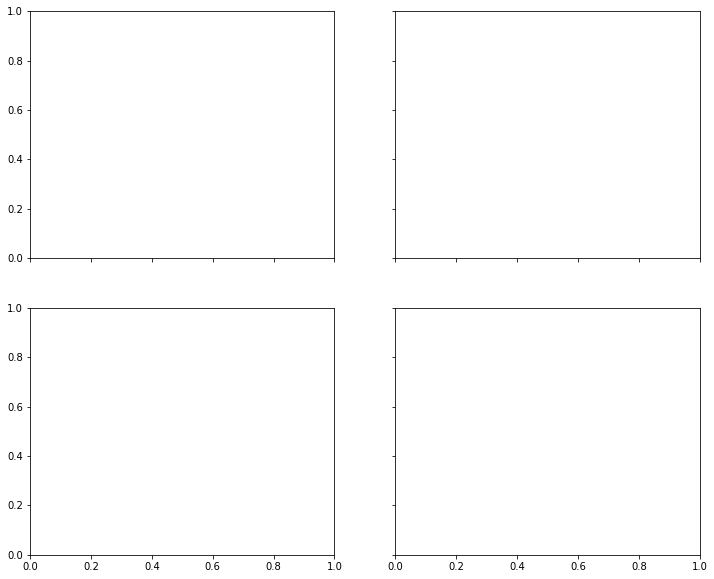

In [13]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['homogeneous_30','homogeneous_50','homogeneous_100','homogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"homogeneous.pdf",[[0,0],[0,1],[1,0],[1,1]],[2,2])

In [4]:

BA =  13000 
parameter = ["./utils/CI_ba_params.json"]
attacker= [torch.load('./model/CI_BA_Graph/model_BAGraph_'+str(BA))]


heterogeneous_30
[8, 10, 15, 2, 21, 3, 11, 13, 0, 20]
heterogeneous_50
[11, 19, 22, 29, 3, 10, 16, 26, 9, 25, 0, 6, 12, 15, 27]
heterogeneous_100
[74, 54, 71, 50, 9, 31, 35, 11, 30, 13, 1, 29, 48, 10, 12, 41, 44, 45]
heterogeneous_500
[411, 407, 98, 263, 245, 261, 198, 148, 278, 154, 152, 253, 103, 214, 109, 363, 150, 195, 260, 197, 281, 225, 306, 380, 173, 275, 252, 1, 18, 45, 107, 112, 136, 171, 213, 286, 352, 2, 28, 32, 34, 42, 62, 64, 65, 88, 91, 125, 167, 219, 243, 244, 247, 264, 279, 338, 358, 383, 398, 22, 35, 50, 113, 145, 157, 227, 242, 251, 259]


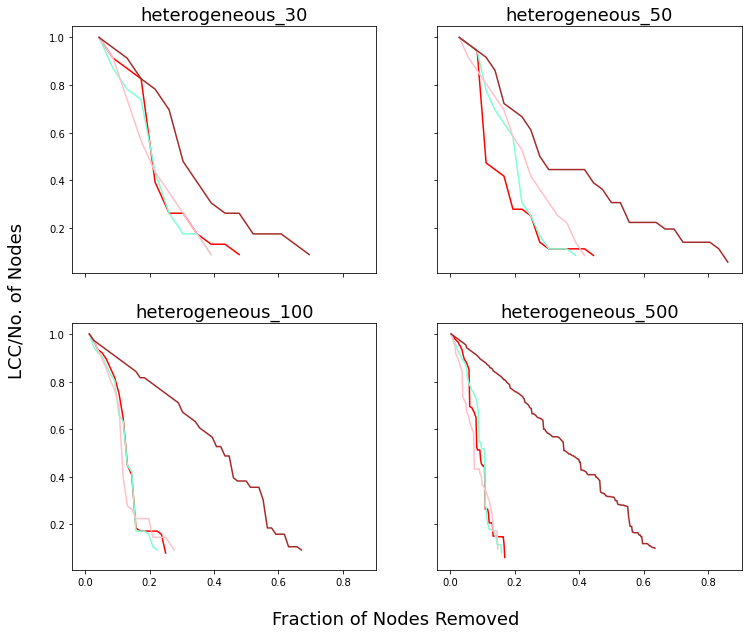

In [5]:
# 'ba_300_100_cycle_5',
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['heterogeneous_30','heterogeneous_50','heterogeneous_100','heterogeneous_500']
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"heterogeneous.pdf",[[0,0],[0,1],[1,0],[1,1]],[2,2])


In [6]:

BA =  13000 
parameter = ["./utils/CI_ba_params.json"]
attacker= [torch.load('./model/CI_BA_Graph/model_BAGraph_'+str(BA))]

corruption
[99, 124, 71, 22, 58, 127, 96, 133, 32, 119, 101, 183, 100, 1, 47, 117, 120, 192, 126, 129, 27, 112, 4, 91, 164, 24, 92, 165, 93, 166, 38, 94, 167, 44, 95, 168, 97, 169, 73, 98, 170, 102, 171, 103, 172, 69, 104, 173, 82]
foodweb-baywet
[64, 17, 54, 38, 50, 49, 55, 69, 31, 93, 28, 101, 40, 66, 68, 47, 102, 29, 33, 52, 114, 71, 51, 119, 100, 87, 86, 34, 123, 27, 67, 39, 72, 30, 88, 94, 74, 95, 35, 56, 124, 103, 21, 22, 23, 80, 32, 0, 41, 42, 125, 61, 48, 73, 25, 37, 53, 26, 36, 18, 24, 85, 62, 127, 91, 20, 77, 104, 84, 19, 14, 122, 9, 16]
inf-USAir97
[60, 25, 74, 72, 56, 62, 57, 67, 23, 24, 54, 27, 76, 124, 26, 73, 28, 129, 134, 5, 120, 152, 126, 66, 127, 50, 22, 77, 61, 68, 55, 3, 52, 75, 135, 133, 125, 37, 319, 10, 29, 123, 63, 53, 137, 65, 213, 100, 47, 51, 44, 64, 106, 204, 200, 104, 49, 78, 4, 110, 203, 286, 115]
moreno_crime_projected
[103, 120, 0, 19, 115, 131, 180, 130, 339, 273, 162, 64, 102, 338, 149, 21, 175, 213, 272, 23, 188, 214, 283, 51, 78, 375, 336, 432, 136, 

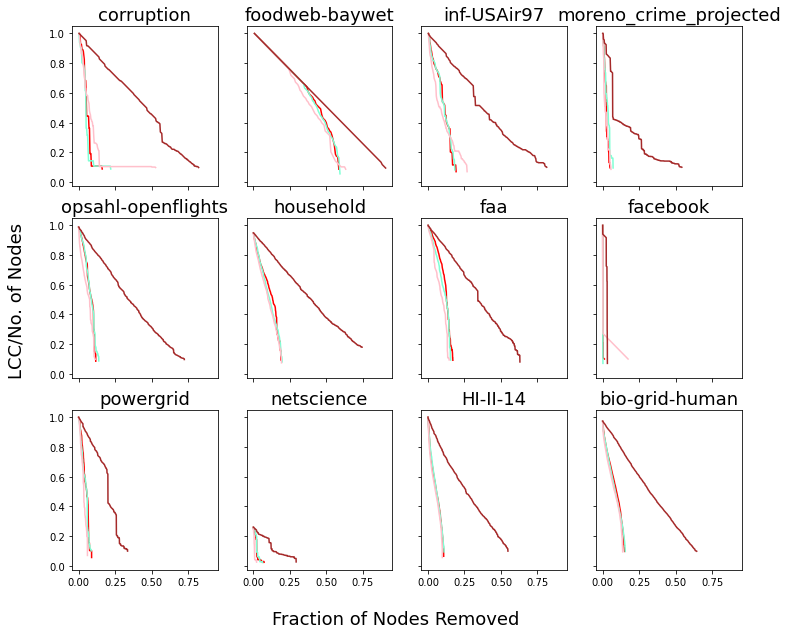

In [7]:
file_list = ['HI-II-14','bio-grid-human']#['Digg_LCC']#['Gnutella31']
#file_list = ['GeneInteraction','ReliableInteraction']#['Gnutella31']bio-grid-human.txt
file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience','HI-II-14','bio-grid-human']
graph_path =  "./Dataset/Real/"
x, y = 3, 4
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"real.pdf",grid_plot,[x,y])


COAD
[319, 2, 8, 297, 6, 7, 18, 490, 38, 4, 1, 457, 566, 1363, 346, 13, 349, 229, 388, 5, 902, 1284, 1362, 3, 321, 438, 1621, 2445, 437, 626, 443, 2145, 292, 420, 94, 300, 1168, 2147, 296, 1955, 2447, 431, 819, 1541, 121, 2161, 1166, 1392, 803, 1532, 145, 403, 1882, 2149, 653, 701, 497, 970, 341, 1321, 2639, 450, 304, 386, 439, 694, 742, 1083, 2151, 2501, 239, 2157, 330, 446, 735, 930, 283, 79, 652, 1194, 384, 1200, 1497, 2167, 462, 1335, 2171, 309, 595, 693, 969, 383, 56, 293, 2175, 2156, 352, 897, 61, 814, 1015, 1028, 2160, 445, 2169, 227, 616, 1048, 1099, 1800, 2141, 2172, 85, 428, 541, 805, 1088, 1135, 278, 2245, 316, 345, 1002, 2069, 2152, 182, 452, 954, 1007, 1179, 1318, 224, 305, 521, 1078, 1801, 2446, 427, 755, 799, 972, 1092, 2148, 415, 619, 651, 756, 887, 1799, 307, 713, 894, 933, 154, 453, 646, 940, 1727, 2189, 2637, 295, 905, 2164, 147, 354, 650, 728, 798, 2451, 338, 402, 794, 899, 1062, 1530, 328, 436, 787, 1161, 1571, 306, 597, 649, 948, 1395, 2058, 2468, 2645, 124, 289, 

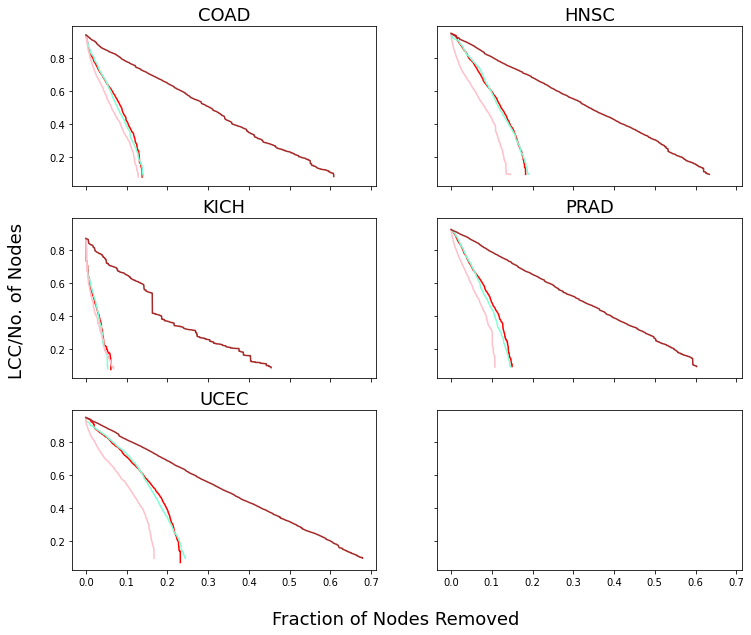

In [8]:
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD","UCEC"]
x, y = 3, 2
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"geneinteraction.pdf",grid_plot,[x,y])


FileNotFoundError: [Errno 2] No such file or directory: './Dataset/Real/Digg_LCC.txt'

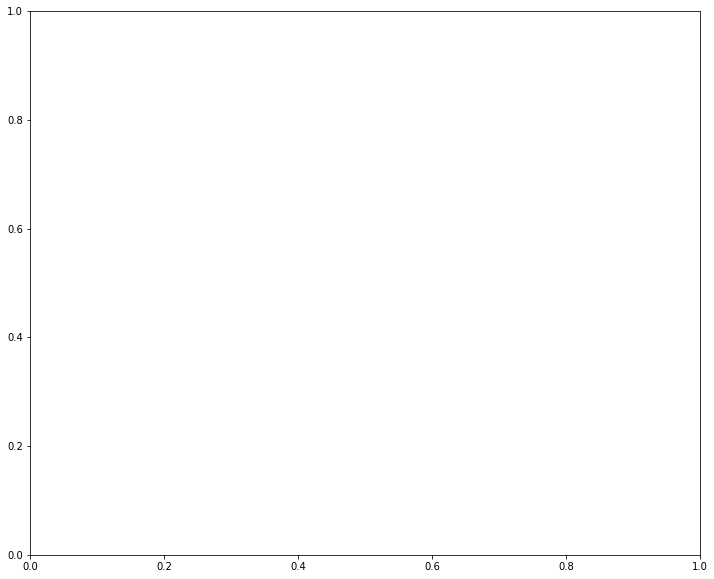

In [9]:
file_list = ['Digg_LCC','Gnutella31']
graph_path =  "./Dataset/Real/"
x, y = 1, 1
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"large.pdf",grid_plot,[x,y])
